In [80]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

from sklearn.datasets import load_boston
import pandas as pd
data = pd.read_csv(load_boston()['filename'], skiprows=1)

In [81]:
#print(load_boston()['DESCR'])

In [82]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677082,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


#### По основным статистическим показателям аномалий и выбросов не видно. Подозрительные параметры, которые нужно иссследовать: CRIM, ZN, B. По смыслу все параметры могут оказывать влияние на медианную величину показателя MEDV

In [83]:
data.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

#### Пустот тоже нет

#### Посмотрим на подозрительный колонки графичкски

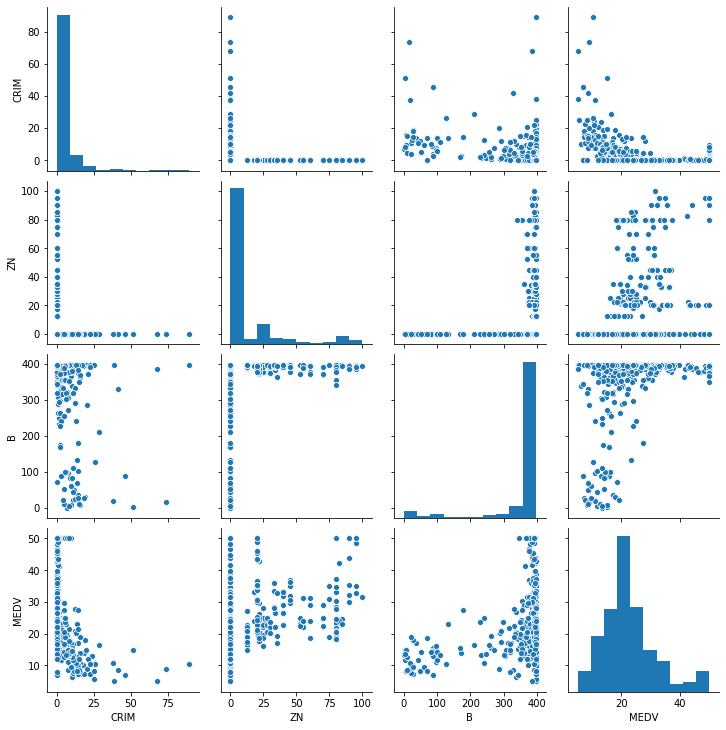

In [84]:
sns.pairplot(data[['CRIM','ZN','B','MEDV']]);


#### По пораметру CRIM видно, что после значения 25 есть несколько показаний выше этого порога. Но разброс по стоимости не велик, поэтому можно все значения выше 25 приравнять к 30. 

#### По параметру ZN выбросов не наблюдается. Разве что для значения ZN=25 есть подозрительно аномальные наблюдения где MEDV>40. Это поведение надо обсуждат с держателями видения предметной области.

#### По параметру B выпадающие значения коррелируют с MEDV. Для весов по выпадающим значениям B может имеет смысл, сначения B [0:200] приравнять к 200.  

##### Остальные пары

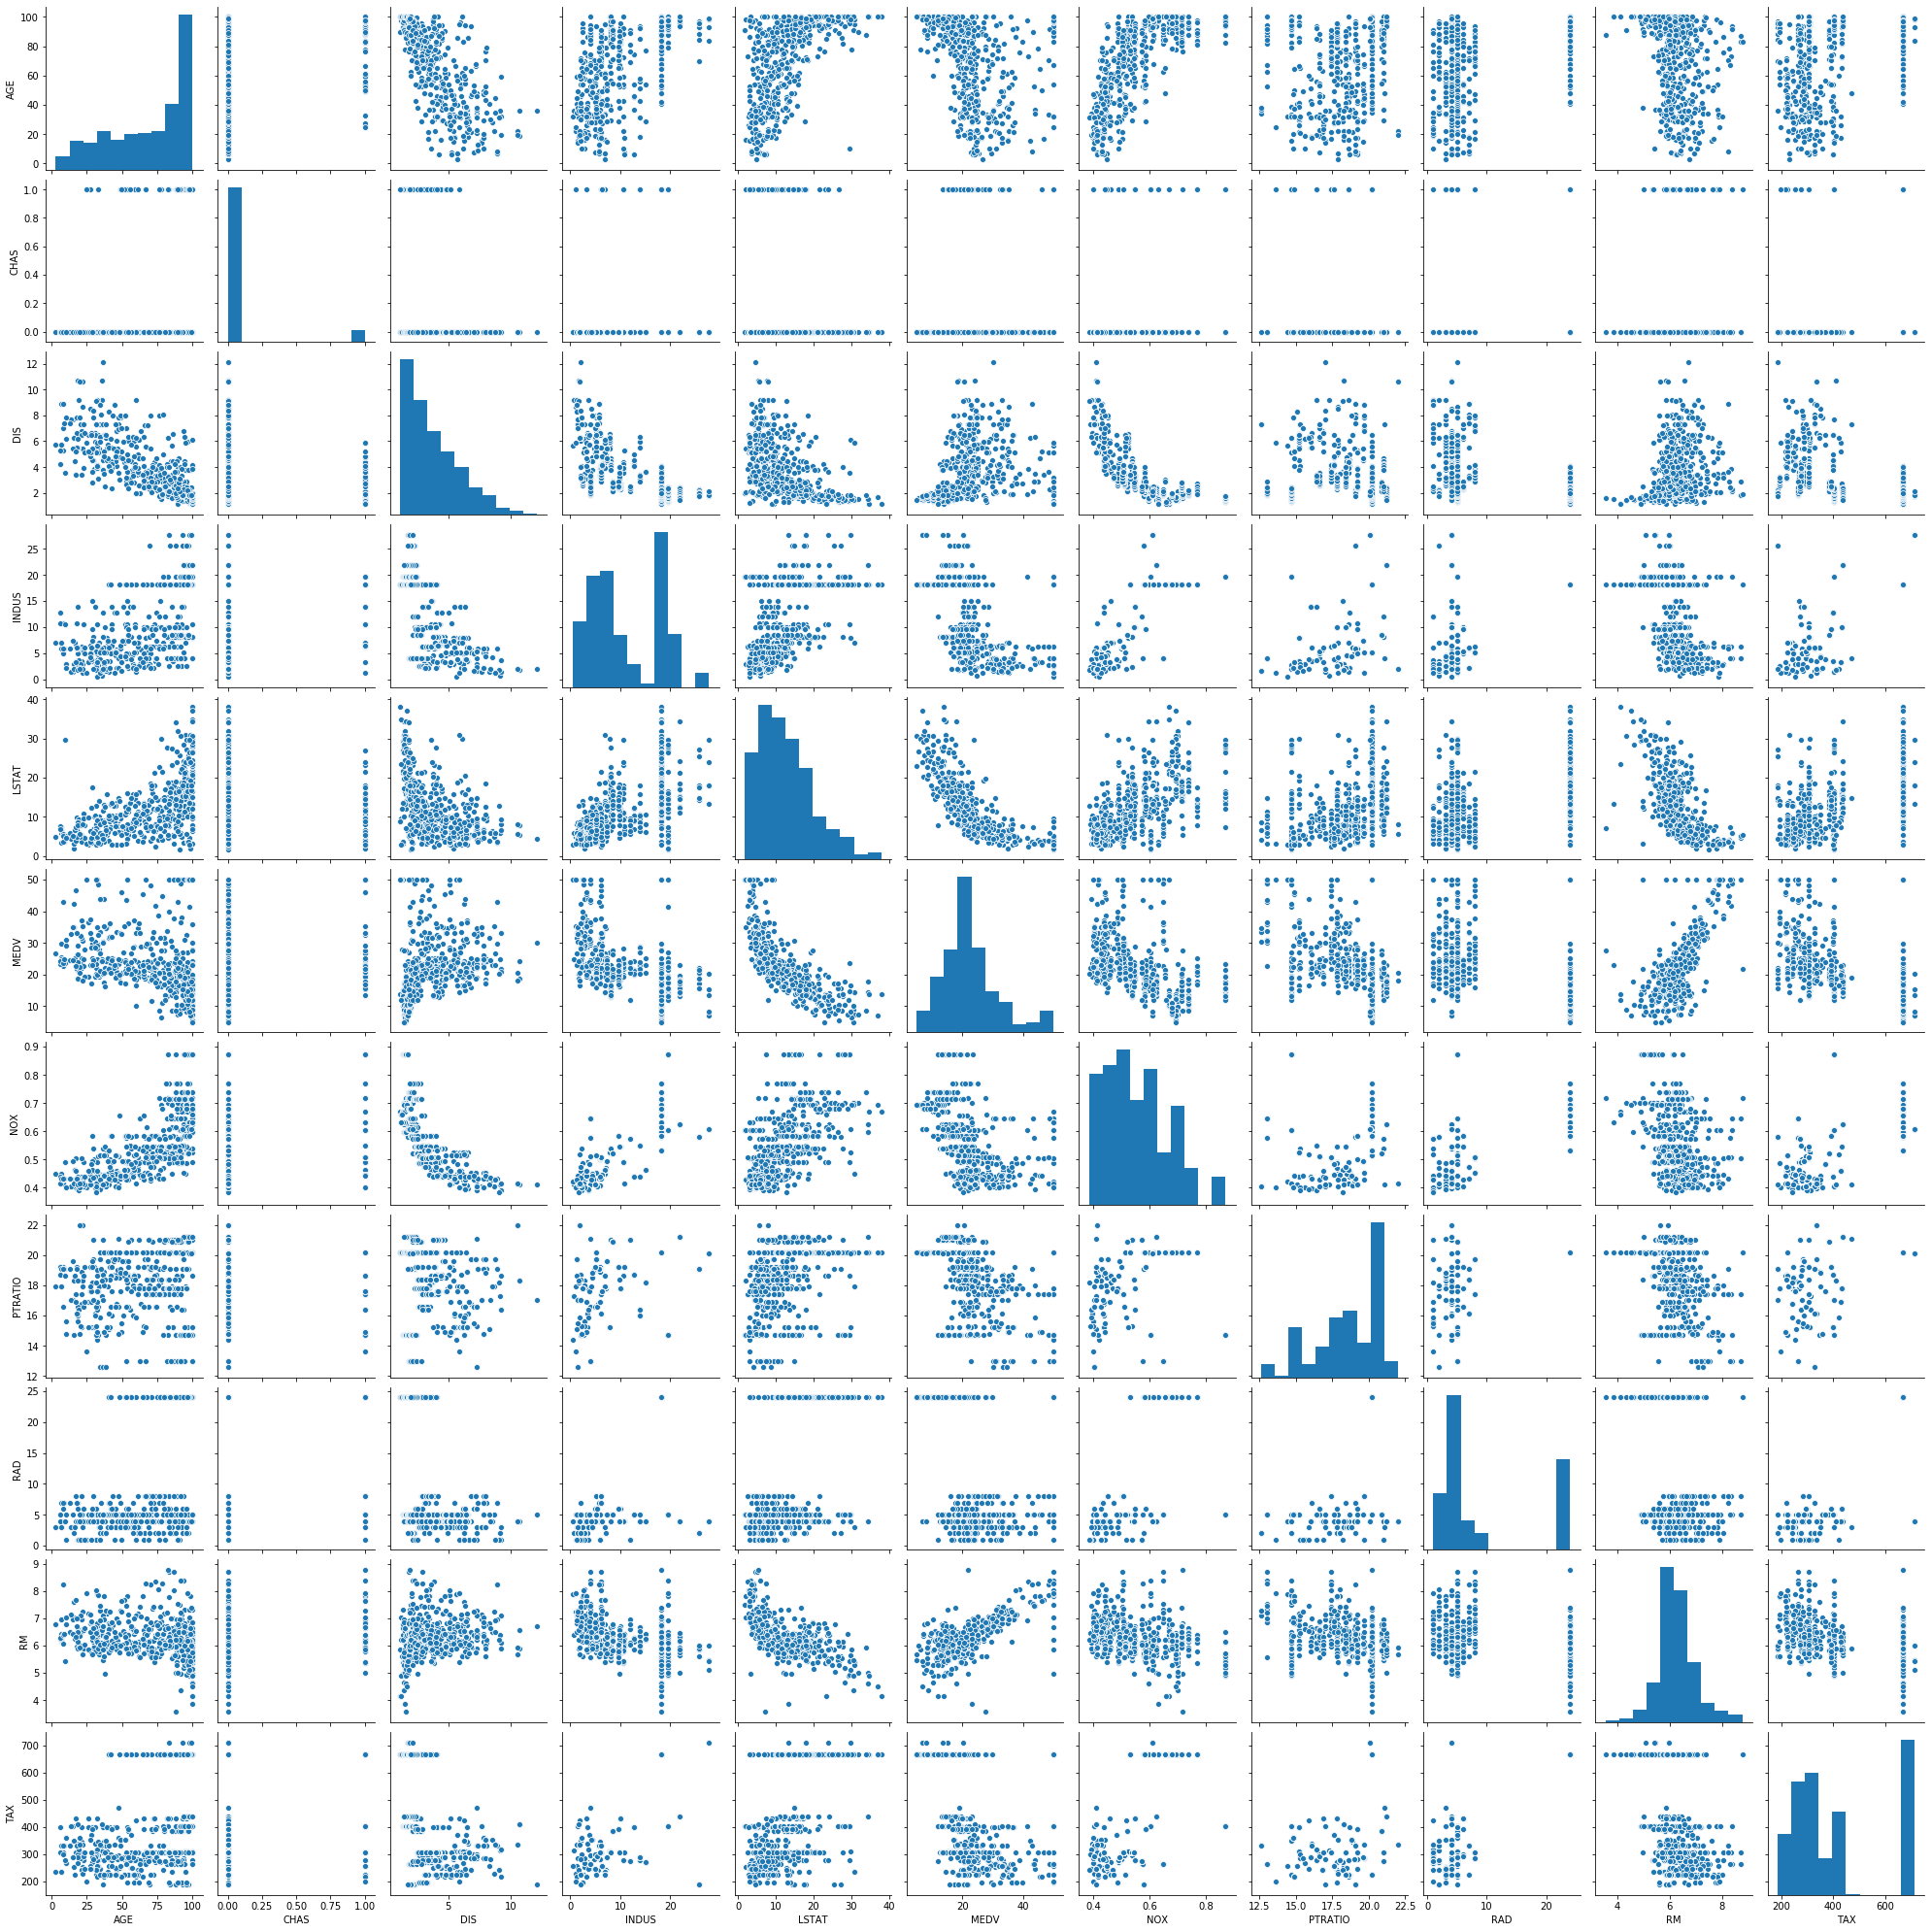

In [85]:
sns.pairplot(data[data.columns.difference(['CRIM','ZN','B'])]);

#### Проглядывается отличная зависимость MEDV с LSTAT

##### Делим выборку на тренировочную и тестовую

In [86]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[data.columns.difference(['MEDV'])], data['MEDV'], test_size=0.2, random_state=30)

##### Обучаем модель линейной регресии на тренировочных данных. И проверяем на тестовых.

In [87]:
reg = LinearRegression().fit(X_train, y_train)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

y_pred = reg.predict(X_test)
print('Error: {}'.format(mean_absolute_error(y_test, y_pred)))
print('MEDV.mean: {}'.format(data['MEDV'].mean()))
print('MEDV.meian: {}'.format(data['MEDV'].median()))

Weights: [ 5.71160169e-03  7.35729616e-03  3.24554801e+00 -1.10214967e-01
 -1.52545323e+00  1.80366661e-02 -5.61078681e-01 -1.87109384e+01
 -9.77173081e-01  3.21188947e-01  3.74450628e+00 -1.33423934e-02
  4.10654046e-02]
Bias: 39.08458849571474
Error: 3.2254104069763274
MEDV.mean: 22.532806324110698
MEDV.meian: 21.2


#### Среднее и медианное значения 21-22. Средняя ошибка по абсолютному значению ~ 3. Вроде не плохой результат.

#### Теперь посмотрим, улучшит ли модель наши наблюдения.

In [88]:
data[data.columns.difference(['MEDV'])].columns

Index(['AGE', 'B', 'CHAS', 'CRIM', 'DIS', 'INDUS', 'LSTAT', 'NOX', 'PTRATIO',
       'RAD', 'RM', 'TAX', 'ZN'],
      dtype='object')

#### Параметр CRIM имеет тяжелый правый хвост. 

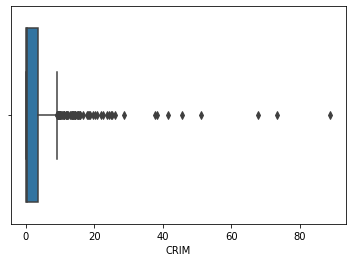

In [89]:
ax = sns.boxplot(x=data['CRIM'])

#### облегчим правуй ус. 

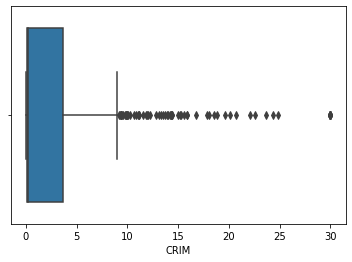

In [90]:
data['CRIM'] = data['CRIM'].apply(lambda rt:30 if rt>25 else rt)
ax = sns.boxplot(x=data['CRIM'])

#### Удалим точки, которые вызывают сомнения 

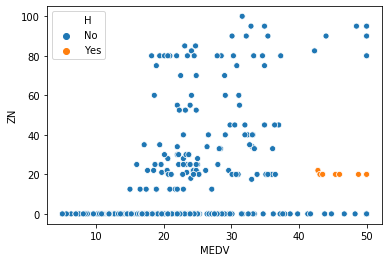

In [104]:
#data.apply(lambda rt: 'Yes' if ((rt['ZN']<20)&(rt['MEDV']>40)) else 'No' )
data['H'] = data.apply(lambda rt: 'Yes' if (((rt['ZN']==22)|(rt['ZN']==20))&(rt['MEDV']>40)) else 'No', axis=1)
ax = sns.scatterplot(x="MEDV", y="ZN",data=data,hue="H")

(498, 15)
(498, 14)


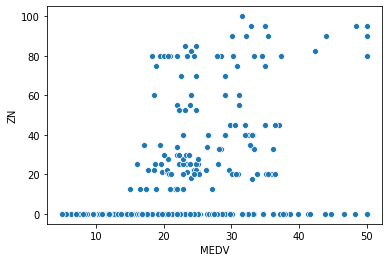

In [110]:
print(data.shape)
data = data.loc[data['H']=='No']
data.drop(['H'], axis=1, inplace=True)
print(data.shape)

ax = sns.scatterplot(x="MEDV", y="ZN",data=data)

#### Подтянем значения параметра B ниже 200 к 200

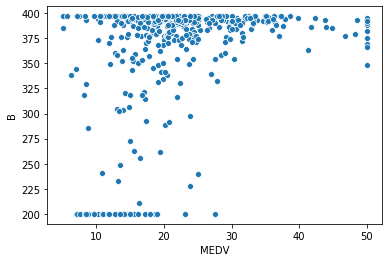

In [111]:
ax = sns.scatterplot(x="MEDV", y="B",data=data)

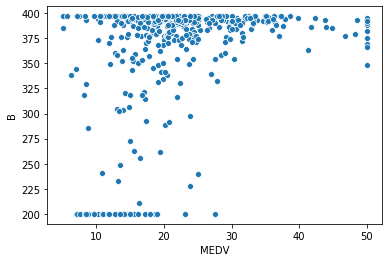

In [107]:
data['B'] = data['B'].apply(lambda rt:200 if rt<200 else rt)
ax = sns.scatterplot(x="MEDV", y="B",data=data)

#### Построим линейную модель а обновленных даных

In [112]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(data[data.columns.difference(['MEDV'])], data['MEDV'], test_size=0.2, random_state=30)

In [113]:
reg = LinearRegression().fit(X_train1, y_train1)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

y_pred1 = reg.predict(X_test1)
print('Error: {}'.format(mean_absolute_error(y_test1, y_pred1)))
print('MEDV.mean: {}'.format(data['MEDV'].mean()))
print('MEDV.meian: {}'.format(data['MEDV'].median()))

Weights: [ 7.93985600e-03  1.15089463e-02  3.58764471e+00 -2.05461943e-01
 -1.53856130e+00  3.02519459e-02 -5.64237546e-01 -2.06829243e+01
 -9.14518219e-01  3.65900928e-01  3.14403525e+00 -1.22283493e-02
  5.34042235e-02]
Bias: 40.130837046833975
Error: 3.6534265295625685
MEDV.mean: 22.15261044176709
MEDV.meian: 21.05


#### По результату ошибки видно что качество модели ухудшилось. Следовательно, так делать как мы нельзя. Однако цель работы проработать с методами визульальной оценки параметнов. Поэтому цель работы достигнута.
